## SAM 能力验证

导入相关的包

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## 测试图片

In [3]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

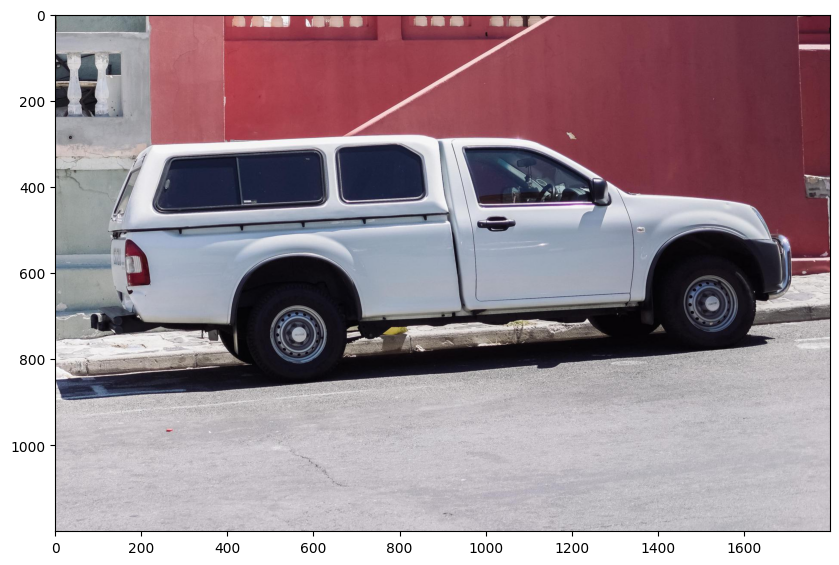

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## 使用SAM分割

In [5]:
from segment_anything import sam_model_registry, SamPredictor
# 模型权重文件
sam_checkpoint = "sam_vit_b_01ec64.pth"
# 模型类型
model_type = "vit_b"
# 使用GPU
device = "cuda"
# 加载模型
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# 将模型放到GPU上
sam.to(device=device)
# 创建预测器
predictor = SamPredictor(sam)

In [6]:
# 使用`SamPredictor.set_image`生成embedding。 `SamPredictor`将记住这个值，并将其用于后续的掩膜预测。
predictor.set_image(image)

In [7]:
# 选择一个点 (x, y) 作为输入
input_point = np.array([[500, 375]])
# 标注这个点的类别，1 表示foreground，即前景点，0 表示background，即背景点
input_label = np.array([1])

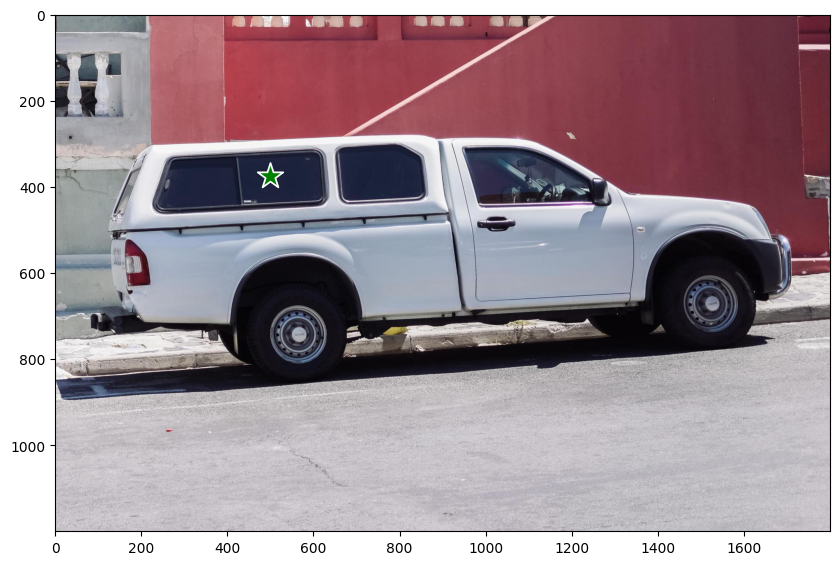

In [8]:
# 绘制检查一下
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [9]:
# 使用预训练模型进行预测，参数：点坐标，点标签，是否输出多分支mask，输出：多分支mask，分数，logits
# 当multimask_output=True时，输出3个分支的mask，为False时，输出1个分支的mask。未解决prompt提示模糊问题，建议使用True，然后通过scores进行筛选
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [10]:
#  (number_of_masks) x H x W
masks.shape

(3, 1200, 1800)

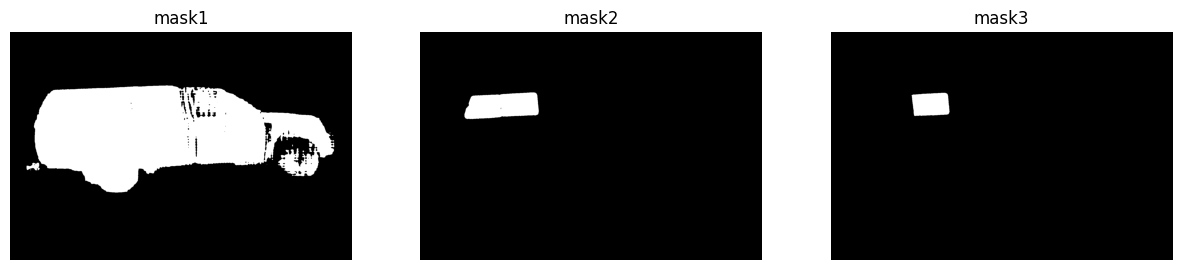

In [11]:
# 分别显示三个mask
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(masks[i], cmap='gray')
    plt.axis('off')
    plt.title('mask'+str(i+1))
plt.show()

In [12]:
# 三个mask的预测分数
scores

array([0.9052793 , 0.95115876, 0.9838574 ], dtype=float32)

In [13]:
# logit是没有经过softmax之前的值
logits.shape

(3, 256, 256)

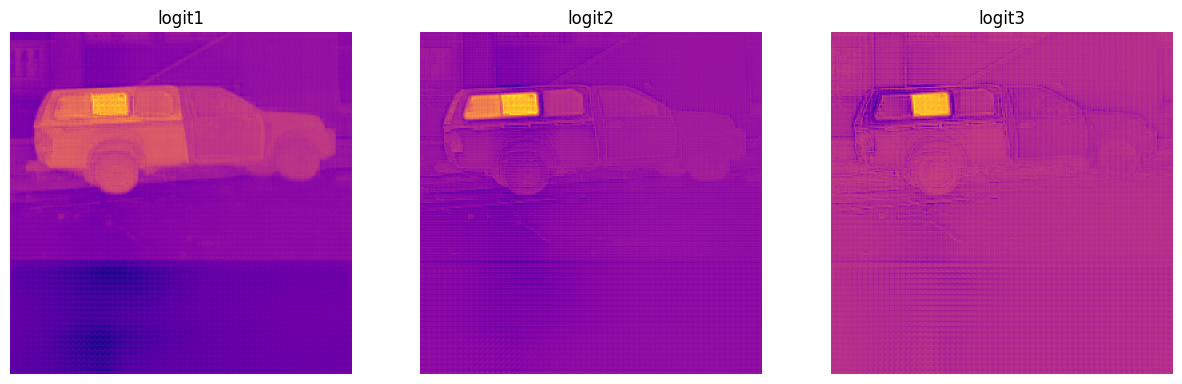

In [14]:
# 分别显示三个logits，logits表示每个像素点属于哪个类别的概率，logits越大，表示该像素点属于该类别的概率越大
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(logits[i], cmap='plasma') # plasma表示热力图，越小越紫，越大越黄
    plt.axis('off')
    plt.title('logit'+str(i+1))
plt.show()

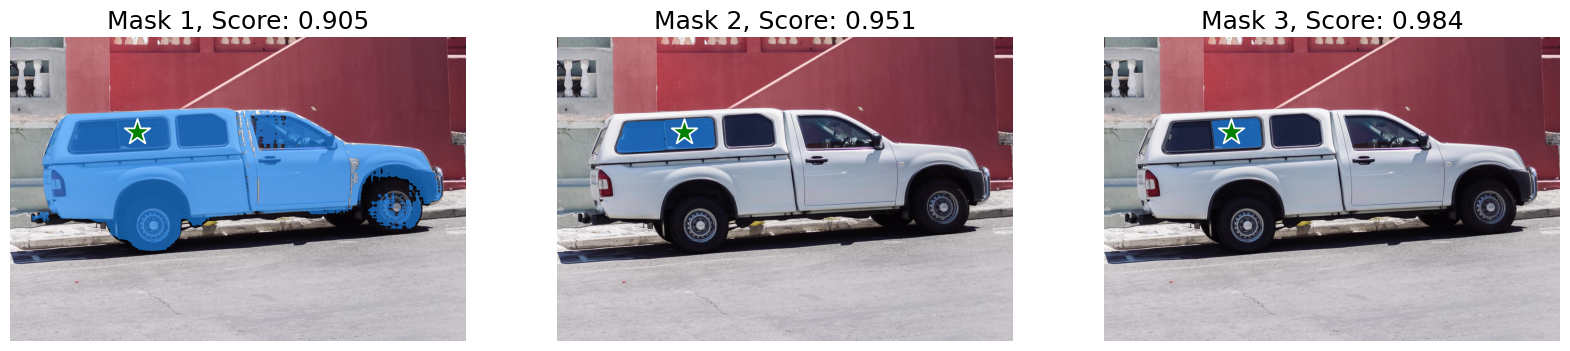

In [15]:
# 将结果绘制在图像上
plt.figure(figsize=(20,10))
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
plt.show()

  

## 使用更多点确定目标

In [16]:
# 输入的2个点坐标
input_point = np.array([[500, 375], [1125, 625]])
# 都是1，表示都是正样本
input_label = np.array([1, 1])

In [17]:
# If available, a mask from a previous iteration can also be supplied to the model to aid in prediction.
# 如果可用，还可以向模型提供来自上一次迭代的掩码以帮助预测。

mask_input = logits[np.argmax(scores), :, :]  # 选择最大的那个类别的logits

In [18]:
# 使用预训练模型进行预测，参数：点坐标，点标签，输入mask，是否输出多个mask（在多点确定一个物体时，可以将此值设为False）

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [19]:
masks.shape

(1, 1200, 1800)

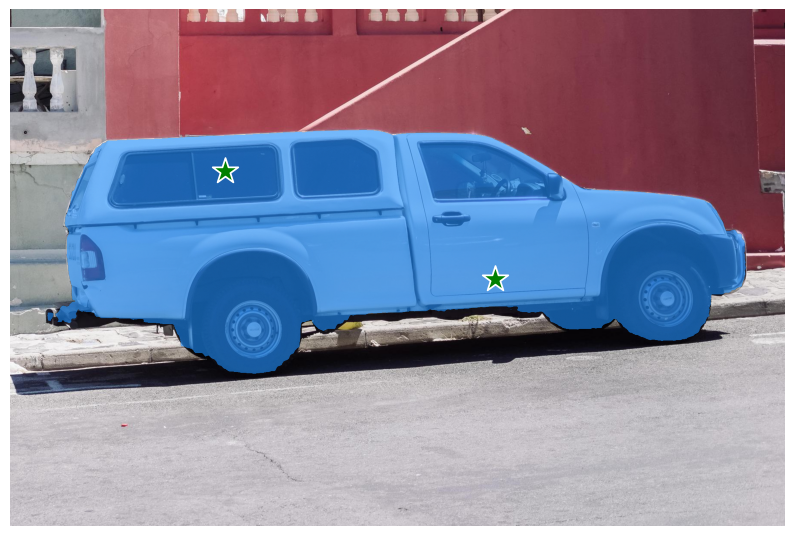

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

In [21]:
# 如果只想要玻璃而不要车身，可以将第二个点的label改为0
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [22]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

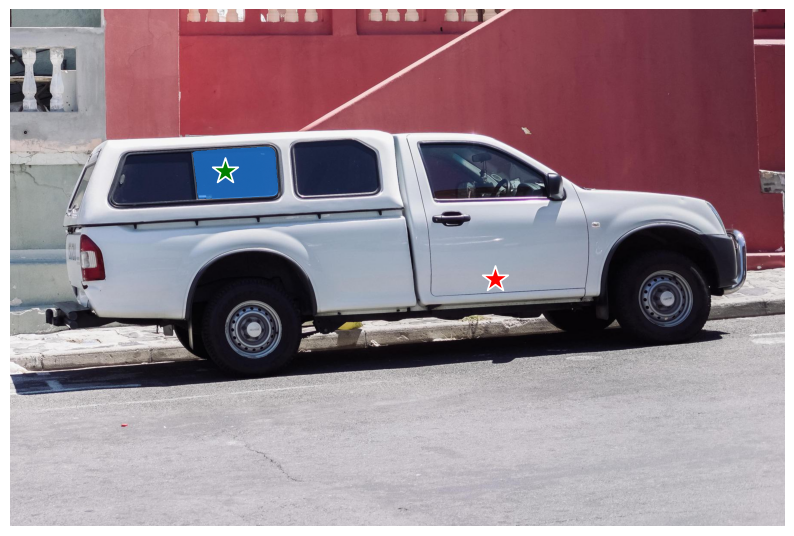

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

## 使用矩形框作为提示

In [24]:
# 矩形框坐标：l, t, r, b
input_box = np.array([425, 600, 700, 875])

In [25]:
# box：shape (n, 4) 
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

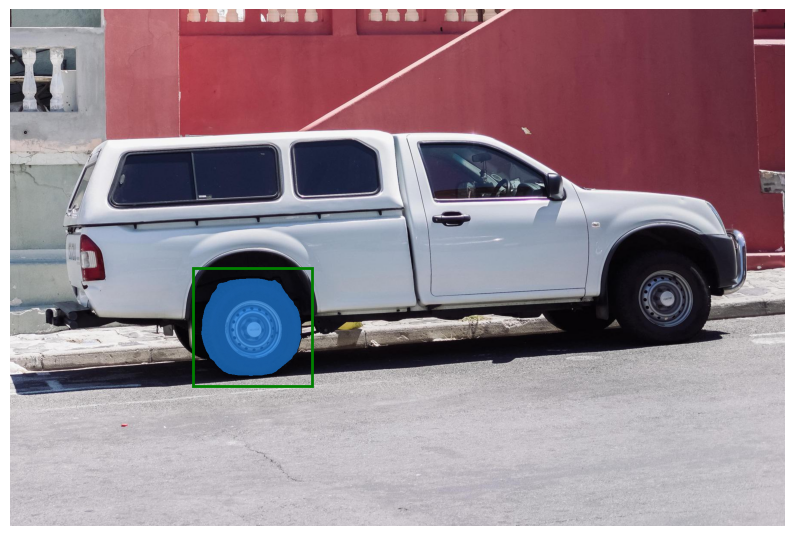

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## 点与矩形框结合提示

In [27]:
# 这里使用电鱼矩形框结合，只选择车轮胎（将车轮胎中心点的label设为0，移除选区）
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [28]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

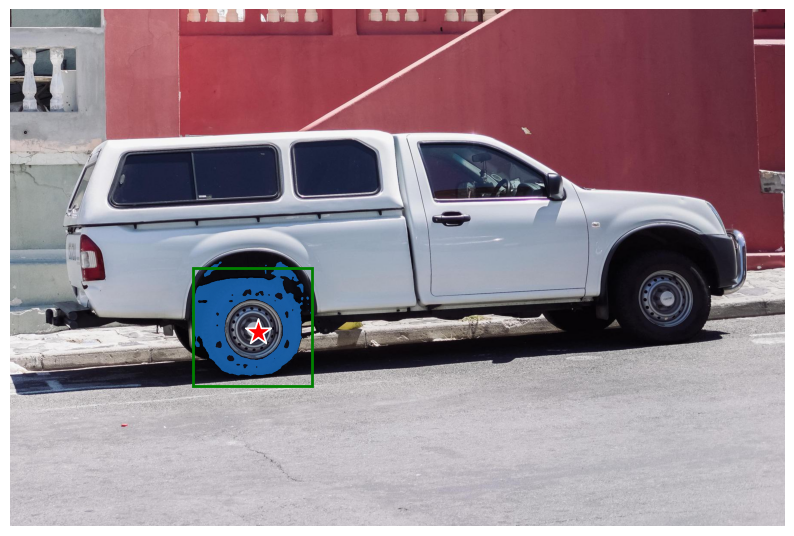

In [29]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()